In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense

import warnings
from collections import Counter
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('F:\\Visconti\\DevProgram\\Tutorial\\Django\\MachineLearning\\DjangoAPI_MachineLearning\\machine_learning\\database\\bankloan.csv')
df = df.dropna()  # Get rid of nonexistent data rows
df.isna().any() # See if has any na left
df = df.drop('Loan_ID', axis=1) # Get red of the column that present the ID of the loan in the data
df['LoanAmount'] = (df['LoanAmount']*1000).astype(int)  # Relative value

balance_res = Counter(df['Loan_Status'])  # Counter create a dictionary and look at any unique variable
ratio_res = Counter(df['Loan_Status'])['Y'] / df['Loan_Status'].size

print(balance_res)
print(ratio_res)

Counter({'Y': 332, 'N': 148})
0.6916666666666667


In [13]:
# Set data with only numbers
pre_X = df.drop('Loan_Status', axis=1)  # Remove the label column
pre_y = df['Loan_Status'] # Grab only the label column

dm_X = pd.get_dummies(pre_X)  # Convert everything into 1's and 0's
dm_y = pre_y.map(dict(Y=1, N=0))  # Convert the Yes into 1 and No into 0

dm_X

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,1.0,4583,1508.0,128000,360.0,1.0,0,1,0,1,1,0,1,0,1,0,0
2,0.0,3000,0.0,66000,360.0,1.0,0,1,0,1,1,0,0,1,0,0,1
3,0.0,2583,2358.0,120000,360.0,1.0,0,1,0,1,0,1,1,0,0,0,1
4,0.0,6000,0.0,141000,360.0,1.0,0,1,1,0,1,0,1,0,0,0,1
5,2.0,5417,4196.0,267000,360.0,1.0,0,1,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,2900,0.0,71000,360.0,1.0,1,0,1,0,1,0,1,0,1,0,0
610,3.0,4106,0.0,40000,180.0,1.0,0,1,0,1,1,0,1,0,1,0,0
611,1.0,8072,240.0,253000,360.0,1.0,0,1,0,1,1,0,1,0,0,0,1
612,2.0,7583,0.0,187000,360.0,1.0,0,1,0,1,1,0,1,0,0,0,1


A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [14]:
smote = SMOTE(sampling_strategy='minority')
X1, y = smote.fit_resample(dm_X, dm_y)  # Balance the samples

In [16]:
sc = MinMaxScaler()
X = sc.fit_transform(X1)  # Rescaling the values to obtain values between zero and one

# Data now is balance
balance_res = Counter(y)  # Counter create a dictionary and look at any unique variable
ratio_res = Counter(y)['Y'] / y.size
print(balance_res)
print(ratio_res)

Counter({0: 332, 1: 332})
0.0


In [18]:
# Divide the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [21]:
# Create the model
classifier = Sequential()

classifier.add(Dense(200, activation='relu', kernel_initializer='random_normal', input_dim=X_test.shape[1]))
classifier.add(Dense(400, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

# Compile the model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
classifier.fit(X_train, y_train, batch_size=20, epochs=100, verbose=0)

# Evaluate the model
eval_model = classifier.evaluate(X_train, y_train)
eval_model

17/17 [==============================] - 0s 875us/step - loss: 0.2377 - accuracy: 0.8908


[0.23768866062164307, 0.8907721042633057]

In [22]:
# Make prediction with the Testset
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.55)  # Threshold for Yes or No answer

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

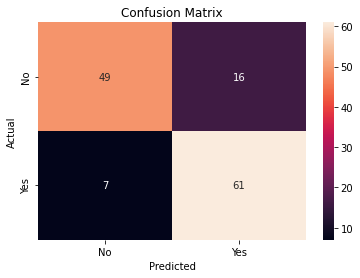

In [23]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)  # annot = True to annotate cells

# Labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

In [24]:
# Saving the model
classifier.save('loan_model')

INFO:tensorflow:Assets written to: loan_model\assets


In [25]:
# Another evaluation proccess
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
csvcores = []

for train, test in kfold.split(X, y):
  # Create model
  model = Sequential()

  model.add(Dense(200, activation='relu', input_dim=17))
  model.add(Dense(400, activation='relu'))
  model.add(Dense(4, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(X[train], y[train], epochs=100, verbose=0)

  scores = model.evaluate(X[train], y[train], verbose=0)

  print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))
  csvcores.append(scores[1] * 100)
  
print('%.2f%% (+/- %.2f%%)' % (np.mean(csvcores), np.std(csvcores)))

accuracy: 90.27%
accuracy: 89.84%
accuracy: 95.26%
91.79% (+/- 2.46%)
